In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use ('fivethirtyeight') # plot theme setting
import warnings
warnings.filterwarnings('ignore') # ignore ignore
%matplotlib inline

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb

In [2]:
# load data
train = pd.read_csv('../_source/train.csv')
test = pd.read_csv('../_source/test.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

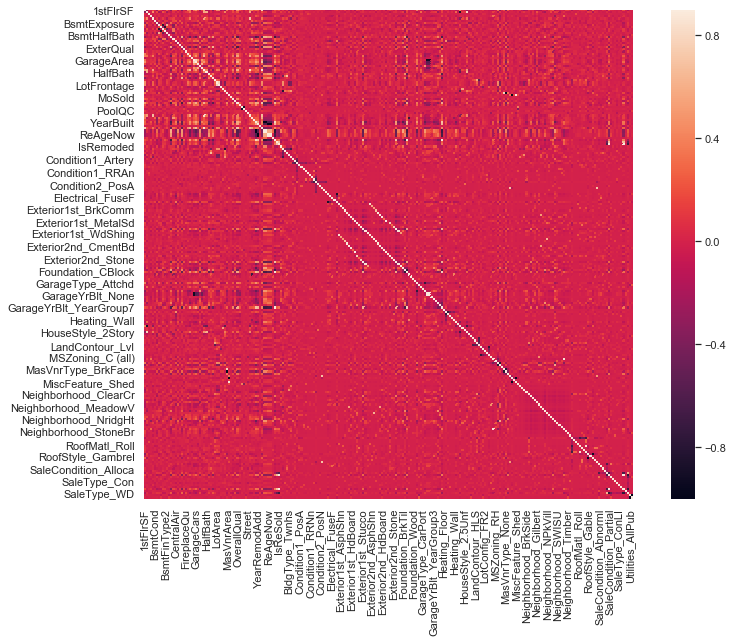

In [33]:
# 相关性热图
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
print(corrmat['SalePrice'].sort_values())

In [ ]:
sns.set()
cols = ['OverallQual', 'GrLivArea','GarageCars', 'GarageArea','TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','SalePrice']
sns.pairplot(train[cols], size = 2.5)
plt.show();

In [ ]:
sns.set()
cols = ['GrLivArea','SalePrice']
sns.pairplot(train[cols], size = 5)
plt.show();

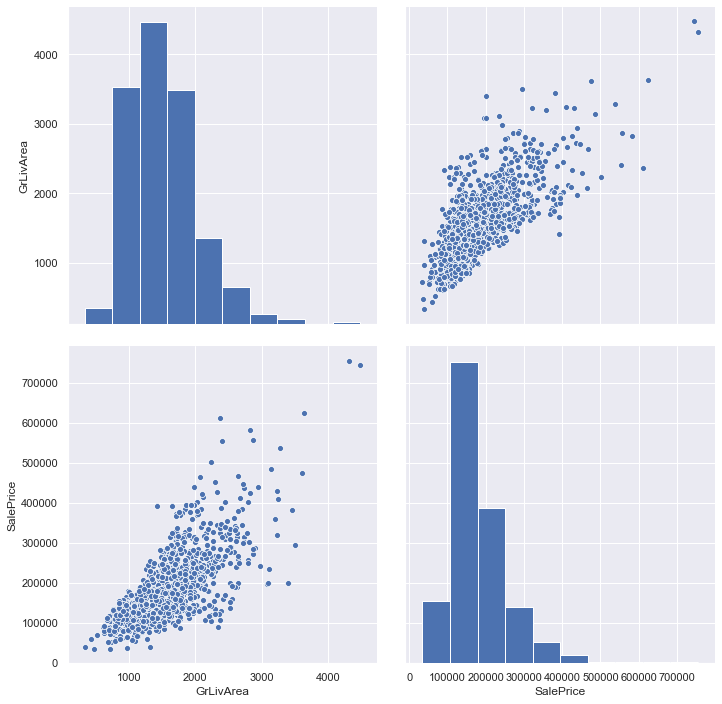

In [3]:
# 删除异常值
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
sns.set()
cols = ['GrLivArea','SalePrice']
sns.pairplot(train[cols], size = 5)
plt.show();

In [16]:
train["SalePrice"] = np.log1p(train["SalePrice"])
ntrain = train.shape[0]
ntest = test.shape[0]
# 保存训练集saleprice
y_train = train.SalePrice.values
# 合并训练集和测试集
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data)

In [17]:
# 缺失值补全-pool相关
poolqcna = all_data[(all_data['PoolQC'].isnull())& (all_data['PoolArea']!=0)][['PoolQC','PoolArea']]
areamean = all_data.groupby('PoolQC')['PoolArea'].mean()
for i in poolqcna.index:
    v = all_data.loc[i,['PoolArea']].values
    print(type(np.abs(v-areamean)))
    all_data.loc[i,['PoolQC']] = np.abs(v-areamean).astype('float64').argmin()
    
all_data['PoolQC'] = all_data["PoolQC"].fillna("None")
all_data['PoolArea'] = all_data["PoolArea"].fillna(0)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [18]:
# 缺失值补全-garage相关
all_data[['GarageCond','GarageFinish','GarageQual','GarageType']] = all_data[['GarageCond','GarageFinish','GarageQual','GarageType']].fillna('None')
all_data[['GarageCars','GarageArea']] = all_data[['GarageCars','GarageArea']].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna( all_data['Electrical'].mode()[0])

In [19]:
# 缺失值补全-basement相关
 
condition = (all_data['BsmtExposure'].isnull()) & (all_data['BsmtCond'].notnull()) # 3个
all_data[condition]['BsmtExposure'] = all_data['BsmtExposure'].mode()[0]
 
condition1 = (all_data['BsmtCond'].isnull()) & (all_data['BsmtExposure'].notnull()) # 3个
all_data[condition1]['BsmtCond'] = all_data.ix[condition1]['BsmtQual']
 
condition2 = (all_data['BsmtQual'].isnull()) & (all_data['BsmtExposure'].notnull()) # 2个
all_data.ix[condition2]['BsmtQual'] = all_data[condition2]['BsmtCond']

condition3 = (all_data['BsmtFinType1'].notnull()) & (all_data['BsmtFinType2'].isnull())
all_data[condition3]['BsmtFinType2'] = 'Unf'

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
# 缺失值补全-masonry veneer相关
MasVnrM = all_data.groupby('MasVnrType')['MasVnrArea'].median()
mtypena = all_data[(all_data['MasVnrType'].isnull())& (all_data['MasVnrArea'].notnull())][['MasVnrType','MasVnrArea']]
for i in mtypena.index:
    v = all_data.loc[i,['MasVnrArea']].values
    all_data.loc[i,['MasVnrType']] = np.abs(v-MasVnrM).astype('float64').argmin()
    
all_data['MasVnrType'] = all_data["MasVnrType"].fillna("None")
all_data['MasVnrArea'] = all_data["MasVnrArea"].fillna(0)

In [21]:
# 缺失值补全-mszoning相关
all_data["MSZoning"] = all_data.groupby("MSSubClass")["MSZoning"].transform(lambda x: x.fillna(x.mode()[0]))

In [22]:
# 缺失值补全-LotFrontage相关
x = all_data.loc[all_data["LotFrontage"].notnull(), "LotArea"]
y = all_data.loc[all_data["LotFrontage"].notnull(), "LotFrontage"]
t = (x <= 25000) & (y <= 150)
p = np.polyfit(x[t], y[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = \
np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

In [23]:
# 缺失值补全-其他
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0]) # 用众数填充
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
all_data["SaleType"] = all_data["SaleType"].fillna(all_data['SaleType'].mode()[0])
all_data["Utilities"] = all_data["Utilities"].fillna(all_data['Utilities'].mode()[0])
 
all_data[["Fence", "MiscFeature"]] = all_data[["Fence", "MiscFeature"]].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')
all_data['Alley'] = all_data['Alley'].fillna('None')

In [24]:
# 缺失值补全-GarageYrBlt
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
# 将年份对应映射
all_data.GarageYrBlt = all_data.GarageYrBlt.map(year_map)
all_data['GarageYrBlt']= all_data['GarageYrBlt'].fillna('None')# 必须 离散化之后再对应映射

In [25]:
# 特征工程
all_data['totalArea']=all_data['GrLivArea']+all_data['TotalBsmtSF']+all_data['GarageArea']+all_data['PoolArea']
all_data['AgeNow']=2010-all_data['YearBuilt']
all_data['AgeSold']=all_data['YrSold']-all_data['YearBuilt']
all_data['ReAgeNow']=2010-all_data['YearRemodAdd']
all_data['ReAgeSold']=all_data['YrSold']-all_data['YearRemodAdd']
# all_data['GarageDelay']=(all_data['GarageYrBlt'])-int(all_data['YearBuilt'])
all_data['IsOld']=all_data['YearBuilt']<1900
all_data['IsNew']=all_data['YearBuilt']>1990
all_data['IsNewSold']=all_data['YearBuilt']>=all_data['YrSold']
all_data['IsReSold']=all_data['YearRemodAdd']>=all_data['YrSold']
all_data['IsRemoded']=all_data['YearRemodAdd']!=all_data['YearBuilt']

In [14]:
from scipy.stats import norm, skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness)


Skew in numerical features: 

                    Skew
MiscVal        21.939672
PoolArea       17.688664
LotArea        13.109495
LowQualFinSF   12.084539
3SsnPorch      11.372080
IsOld          10.449943
LotFrontage     7.624419
IsNewSold       4.733525
KitchenAbvGr    4.300550
BsmtFinSF2      4.144503
EnclosedPorch   4.002344
ScreenPorch     3.945101
BsmtHalfBath    3.929996
IsReSold        3.048650
MasVnrArea      2.621719
OpenPorchSF     2.529358
WoodDeckSF      1.844792
MSSubClass      1.375131
1stFlrSF        1.257286
GrLivArea       1.068750
BsmtFinSF1      0.980645
BsmtUnfSF       0.919688
totalArea       0.908600
2ndFlrSF        0.861556
TotRmsAbvGrd    0.749232
Fireplaces      0.725278
HalfBath        0.696666
TotalBsmtSF     0.671751
BsmtFullBath    0.622415
AgeNow          0.599194
AgeSold         0.598015
OverallCond     0.569314
IsNew           0.516209
ReAgeNow        0.450134
ReAgeSold       0.449364
BedroomAbvGr    0.326568
GarageArea      0.216857
MoSold          0.1

In [26]:
from scipy.special import boxcox1p
t = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
lam = 0.15
for feat in t:
    all_data[feat] = boxcox1p(all_data[feat], lam)  # 对于其他属性，采用boxcox1p较好

In [27]:
# 对于属性值具有对比关系的属性，使用标签编码
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [28]:
all_data = pd.get_dummies(all_data)
train = all_data[:ntrain]
test = all_data[ntrain:]

In [29]:
# 计算RMES
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [30]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1102 (0.0067)



In [31]:
submission = pd.DataFrame()
submission['Id'] = test_ID
reg = lasso.fit(train,y_train)
predictions = lasso.predict(test)

final_predictions = np.exp(predictions)
print ("Final predictions are: \n", final_predictions[:5])
submission['SalePrice'] = final_predictions
submission.to_csv('submission1221.csv', index=False)

Final predictions are: 
 [122151.37619927 151746.11163424 182619.18406808 197410.40525279
 200437.62456941]
